In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_confirmed = pd.read_csv('time_series_2019-ncov-Confirmed.csv')
df_recovered = pd.read_csv('time_series_2019-ncov-Recovered.csv')
df_deaths = pd.read_csv('time_series_2019-ncov-Deaths.csv')

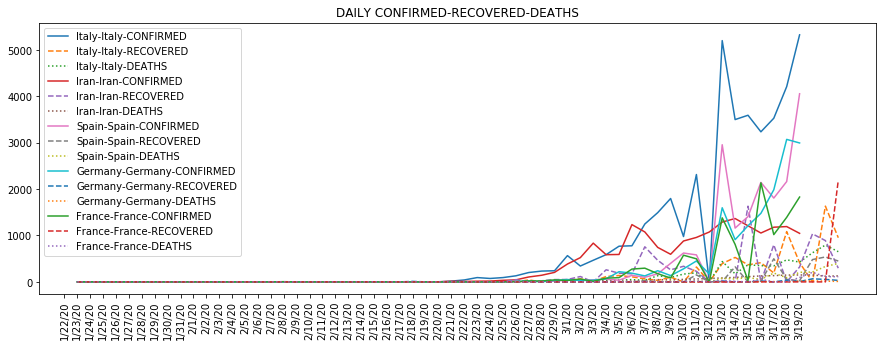

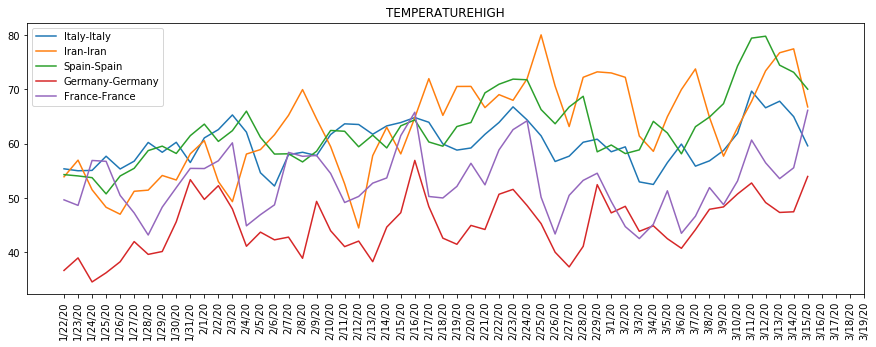

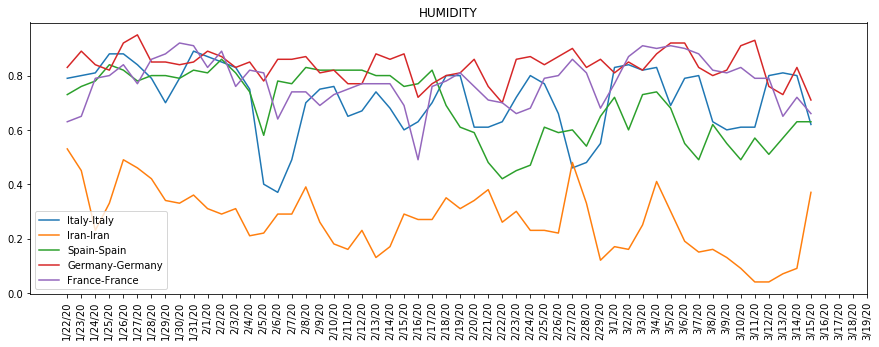

In [14]:
region_idx = 0
last_date = '3-16-20'
conutries= ['Italy','Germany','France','Spain','Korea','Iran','Japan','Switzerland', 
            'United Kingdom','Netherlands','Norway','Sweden','Austria','Belgium'] 
plt.figure(figsize=(15, 5))
plt.title('DAILY CONFIRMED-RECOVERED-DEATHS')
for region_idx in range(len(df_confirmed)):
    region_data = df_confirmed.iloc[region_idx,:-1]
    country = region_data['Country/Region']
    Province_State = region_data['Province/State']
    if "nan"  in str(Province_State):
        Province_State = country
    if Province_State not in conutries:
        continue
    name = 'weather/'+country+"-"+Province_State+"-"+last_date+"20.csv"

    #confirmed daily
    values = region_data.iloc[4:].values
    values = pd.Series(values).astype(float).diff().astype(float)
    plt.plot(values,label = country+"-"+Province_State+'-CONFIRMED')
    
    #recovered daily
    recovered = df_recovered[(df_recovered.Lat==region_data.Lat) &
                         (df_recovered.Long==region_data.Long) ]
    values = recovered.iloc[0,4:].values
    values = pd.Series(values).astype(float).diff().astype(float)
    plt.plot(values,label = country+"-"+Province_State+'-RECOVERED',linestyle='dashed')

    #deaths daily
    deaths = df_deaths[(df_deaths.Lat==region_data.Lat) &
                         (df_deaths.Long==region_data.Long) ]
    values = deaths.iloc[0,4:].values
    values = pd.Series(values).astype(float).diff().astype(float)
    plt.plot(values,label = country+"-"+Province_State+'-DEATHS',linestyle='dotted')
    
    if region_idx>5:
        break

plt.xticks(np.arange(len(region_data.iloc[4:])),region_data.iloc[4:].index,rotation='vertical')
plt.legend()
plt.show()

for plt_variable in ['temperatureHigh','humidity']:
    plt.figure(figsize=(15, 5))
    plt.title(plt_variable.upper())
    for region_idx in range(len(df_confirmed)):
        region_data = df_confirmed.iloc[region_idx,:-1]
        country = region_data['Country/Region']
        Province_State = region_data['Province/State']
        if "nan"  in str(Province_State):
            Province_State = country
        if Province_State not in conutries:
            continue
            
        name = 'weather/'+country+"-"+Province_State+"-"+last_date+"20.csv"
        weather_data = pd.read_csv(name,index_col=0)
        values = weather_data[region_data.index[4:-4]+str(20)].loc[plt_variable].values.astype(float)
        
        plt.plot(values,label= country+"-"+Province_State)

        if region_idx>5:
            break
    plt.xticks(np.arange(len(region_data.iloc[4:])),region_data.iloc[4:].index,rotation='vertical')
    plt.legend()
    plt.show()

In [318]:
#for each country calculate correlations between the COVID-19 data and the weather data
corr_dfs_confirmed = []
corr_dfs_recovered = []
corr_dfs_deaths = []

for region_idx in range(len(df_confirmed)):
    try:
        region_data = df_confirmed.iloc[region_idx,:-1]
        country = region_data['Country/Region']
        Province_State = region_data['Province/State']
        if "nan"  in str(Province_State):
            Province_State = country
            
        if sum(region_data.iloc[4:])<=50:
            continue
            
        name = 'weather/'+country+"-"+Province_State+"-"+last_date+"20.csv"
        weather_data = pd.read_csv(name,index_col=0)

        confirmed_daily = region_data.iloc[4:].values
        confirmed_daily = pd.Series(confirmed_daily).astype(float).diff().astype(float)[1:]

        #recovered daily
        recovered = df_recovered[(df_recovered.Lat==region_data.Lat) &
                             (df_recovered.Long==region_data.Long) ]
        recovered_daily = recovered.iloc[0,4:].values
        recovered_daily = pd.Series(recovered_daily).astype(float).diff().astype(float)[1:]

        #deaths daily
        deaths = df_deaths[(df_deaths.Lat==region_data.Lat) &
                             (df_deaths.Long==region_data.Long) ]
        deaths_daily  = deaths.iloc[0,4:].values
        deaths_daily = pd.Series(deaths_daily).astype(float).diff().astype(float)[1:]

        #joint_data
        joint_df = weather_data.copy()
        joint_df = joint_df.drop('1/22/2020',axis=1)

        row_confirmed = pd.DataFrame([confirmed_daily[:len(joint_df.columns)].values],
                                      columns=joint_df.columns.values)

        row_recovered = pd.DataFrame([recovered_daily[:len(joint_df.columns)].values],
                                      columns=joint_df.columns.values)

        row_deaths = pd.DataFrame([deaths_daily[:len(joint_df.columns)].values],
                                  columns=joint_df.columns.values)

        joint_df = pd.concat([joint_df,row_confirmed,row_recovered,row_deaths])

        idx_names = joint_df.index.values
        idx_names[-3] = 'confirmed'
        idx_names[-2] = 'recovered'
        idx_names[-1] = 'deaths'
        joint_df.index  = idx_names
        joint_df = joint_df.T
        joint_df = joint_df.apply(pd.to_numeric, errors='coerce')
        joint_df = joint_df.dropna(axis=1).astype(float)

        corr_confirmed = joint_df.apply(lambda x: x.corr(joint_df['confirmed']))
        corr_recovered = joint_df.apply(lambda x: x.corr(joint_df['recovered']))
        corr_deaths = joint_df.apply(lambda x: x.corr(joint_df['deaths']))

        corr_dfs_confirmed.append(pd.DataFrame(corr_confirmed,columns = [Province_State]))
        corr_dfs_recovered.append(pd.DataFrame(corr_recovered,columns = [Province_State]))
        corr_dfs_deaths.append(pd.DataFrame(corr_deaths,columns = [Province_State]))
    except Exception as e:
        print(e)
        continue

In [319]:
corr_dfs_confirmed = pd.concat(corr_dfs_confirmed,axis=1)
corr_dfs_confirmed = corr_dfs_confirmed.T
corr_dfs_recovered = pd.concat(corr_dfs_recovered,axis=1)
corr_dfs_recovered = corr_dfs_recovered.T
corr_dfs_deaths = pd.concat(corr_dfs_deaths,axis=1)
corr_dfs_deaths = corr_dfs_deaths.T

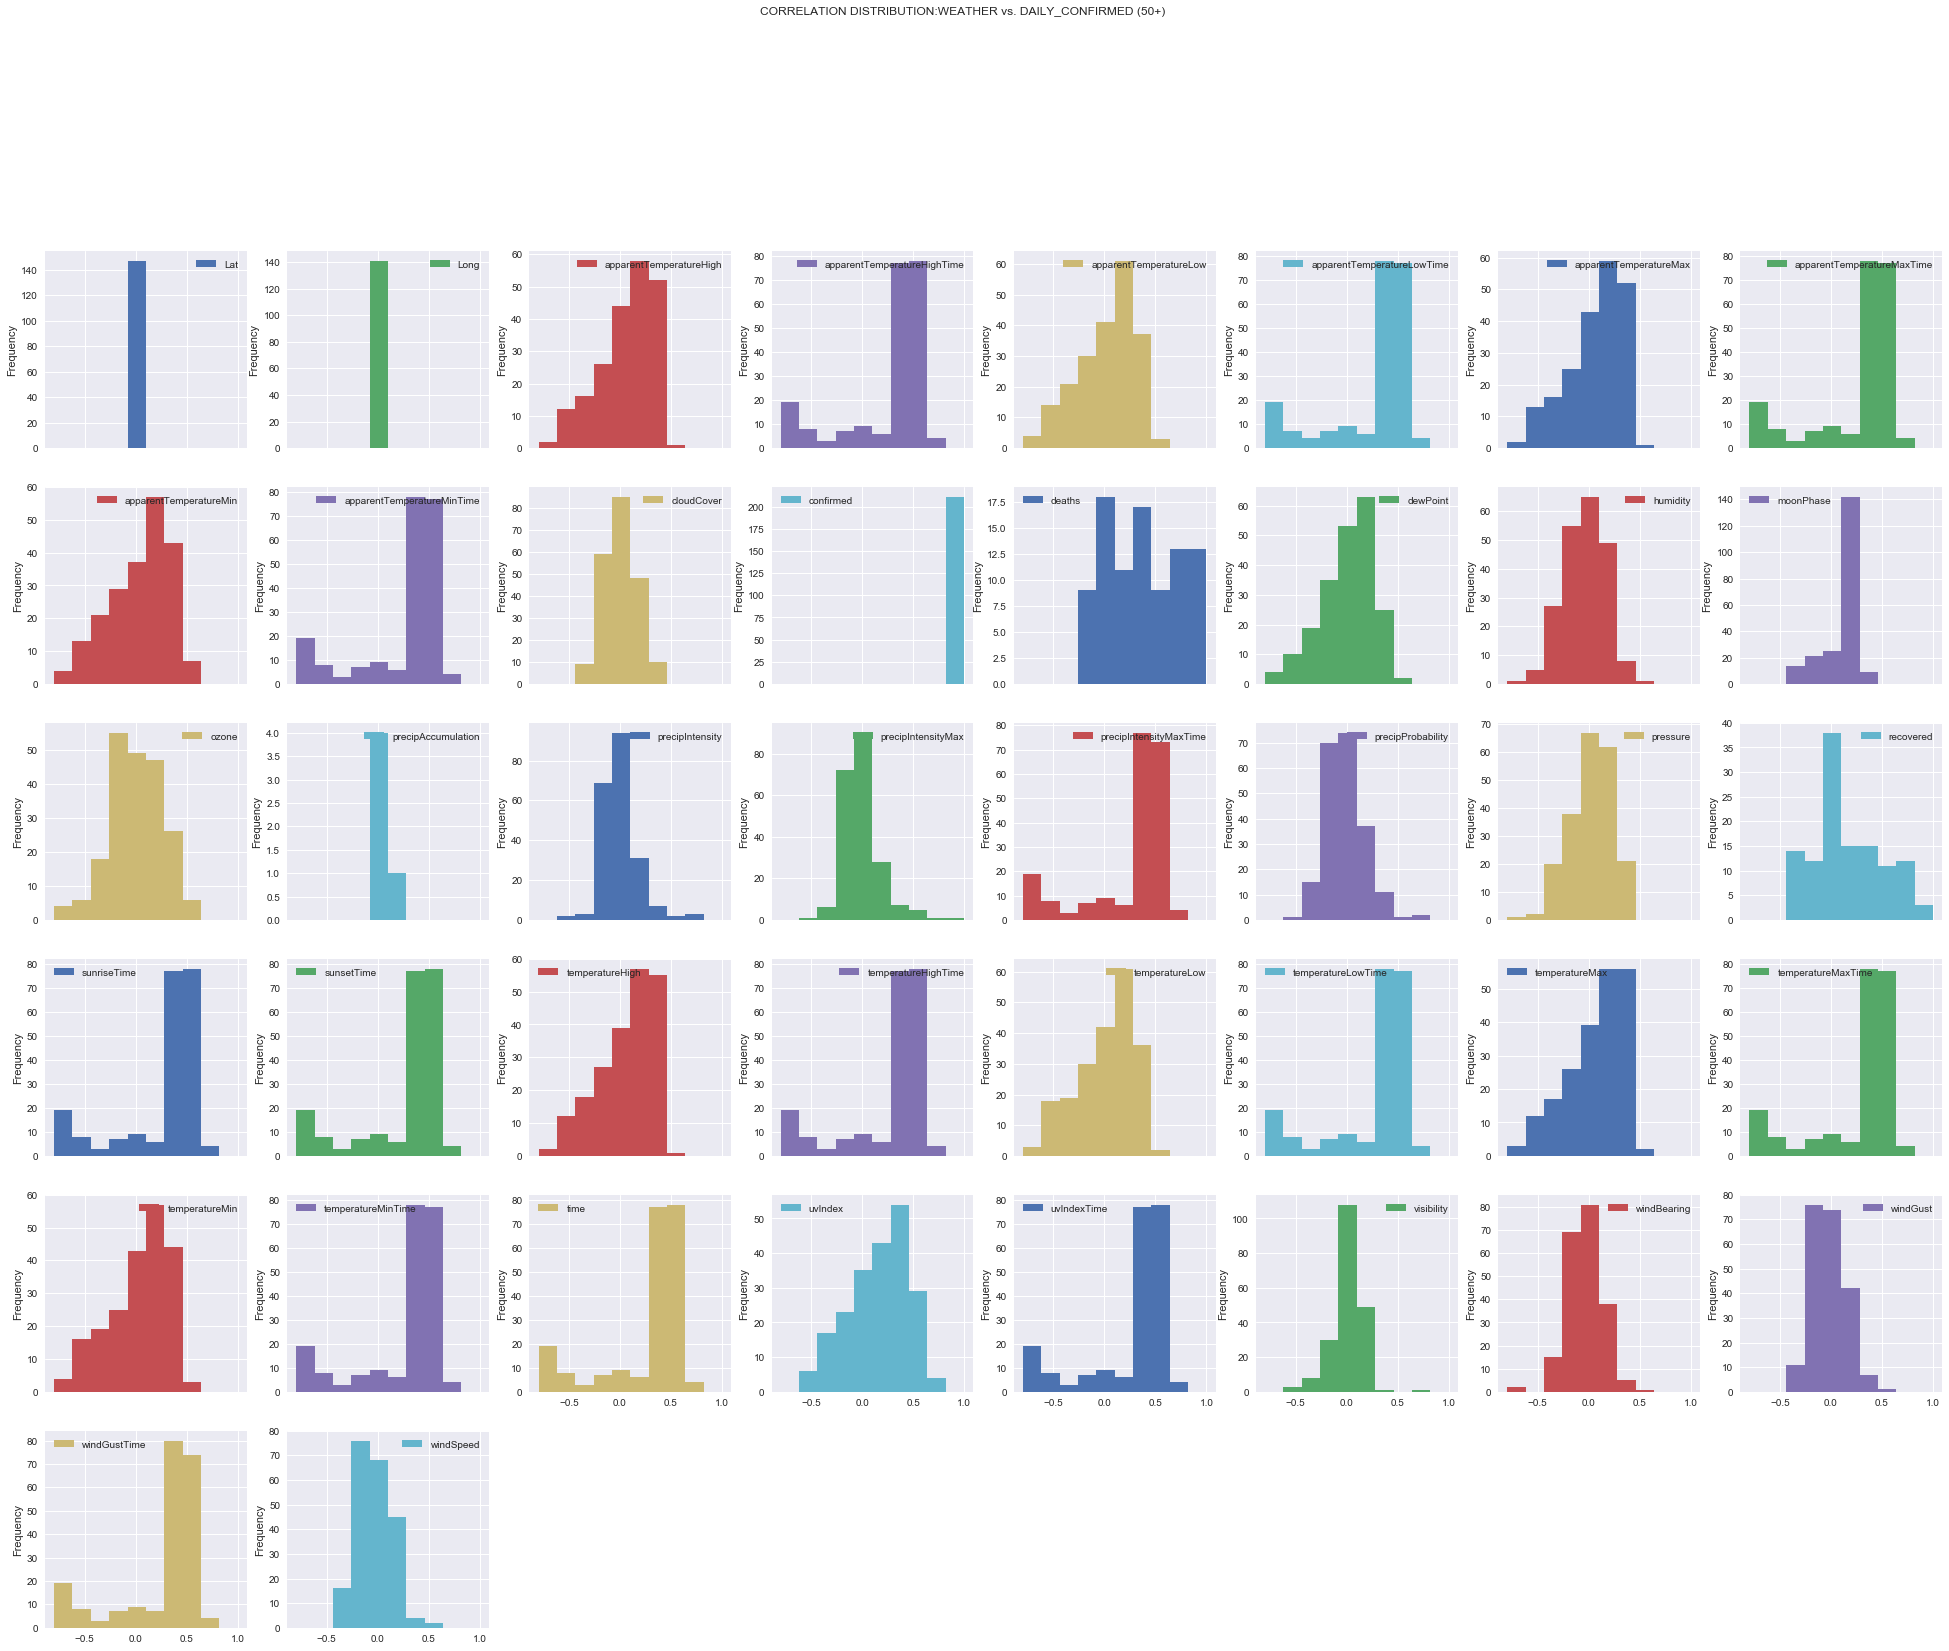

In [340]:
plt.style.use('seaborn')
corr_dfs_confirmed.plot.hist(subplots=True, legend=True, 
                             layout=(8, 8),
                             figsize=(34, 34),
                            title = "CORRELATION DISTRIBUTION:WEATHER vs. DAILY_CONFIRMED (50+)")
plt.show()

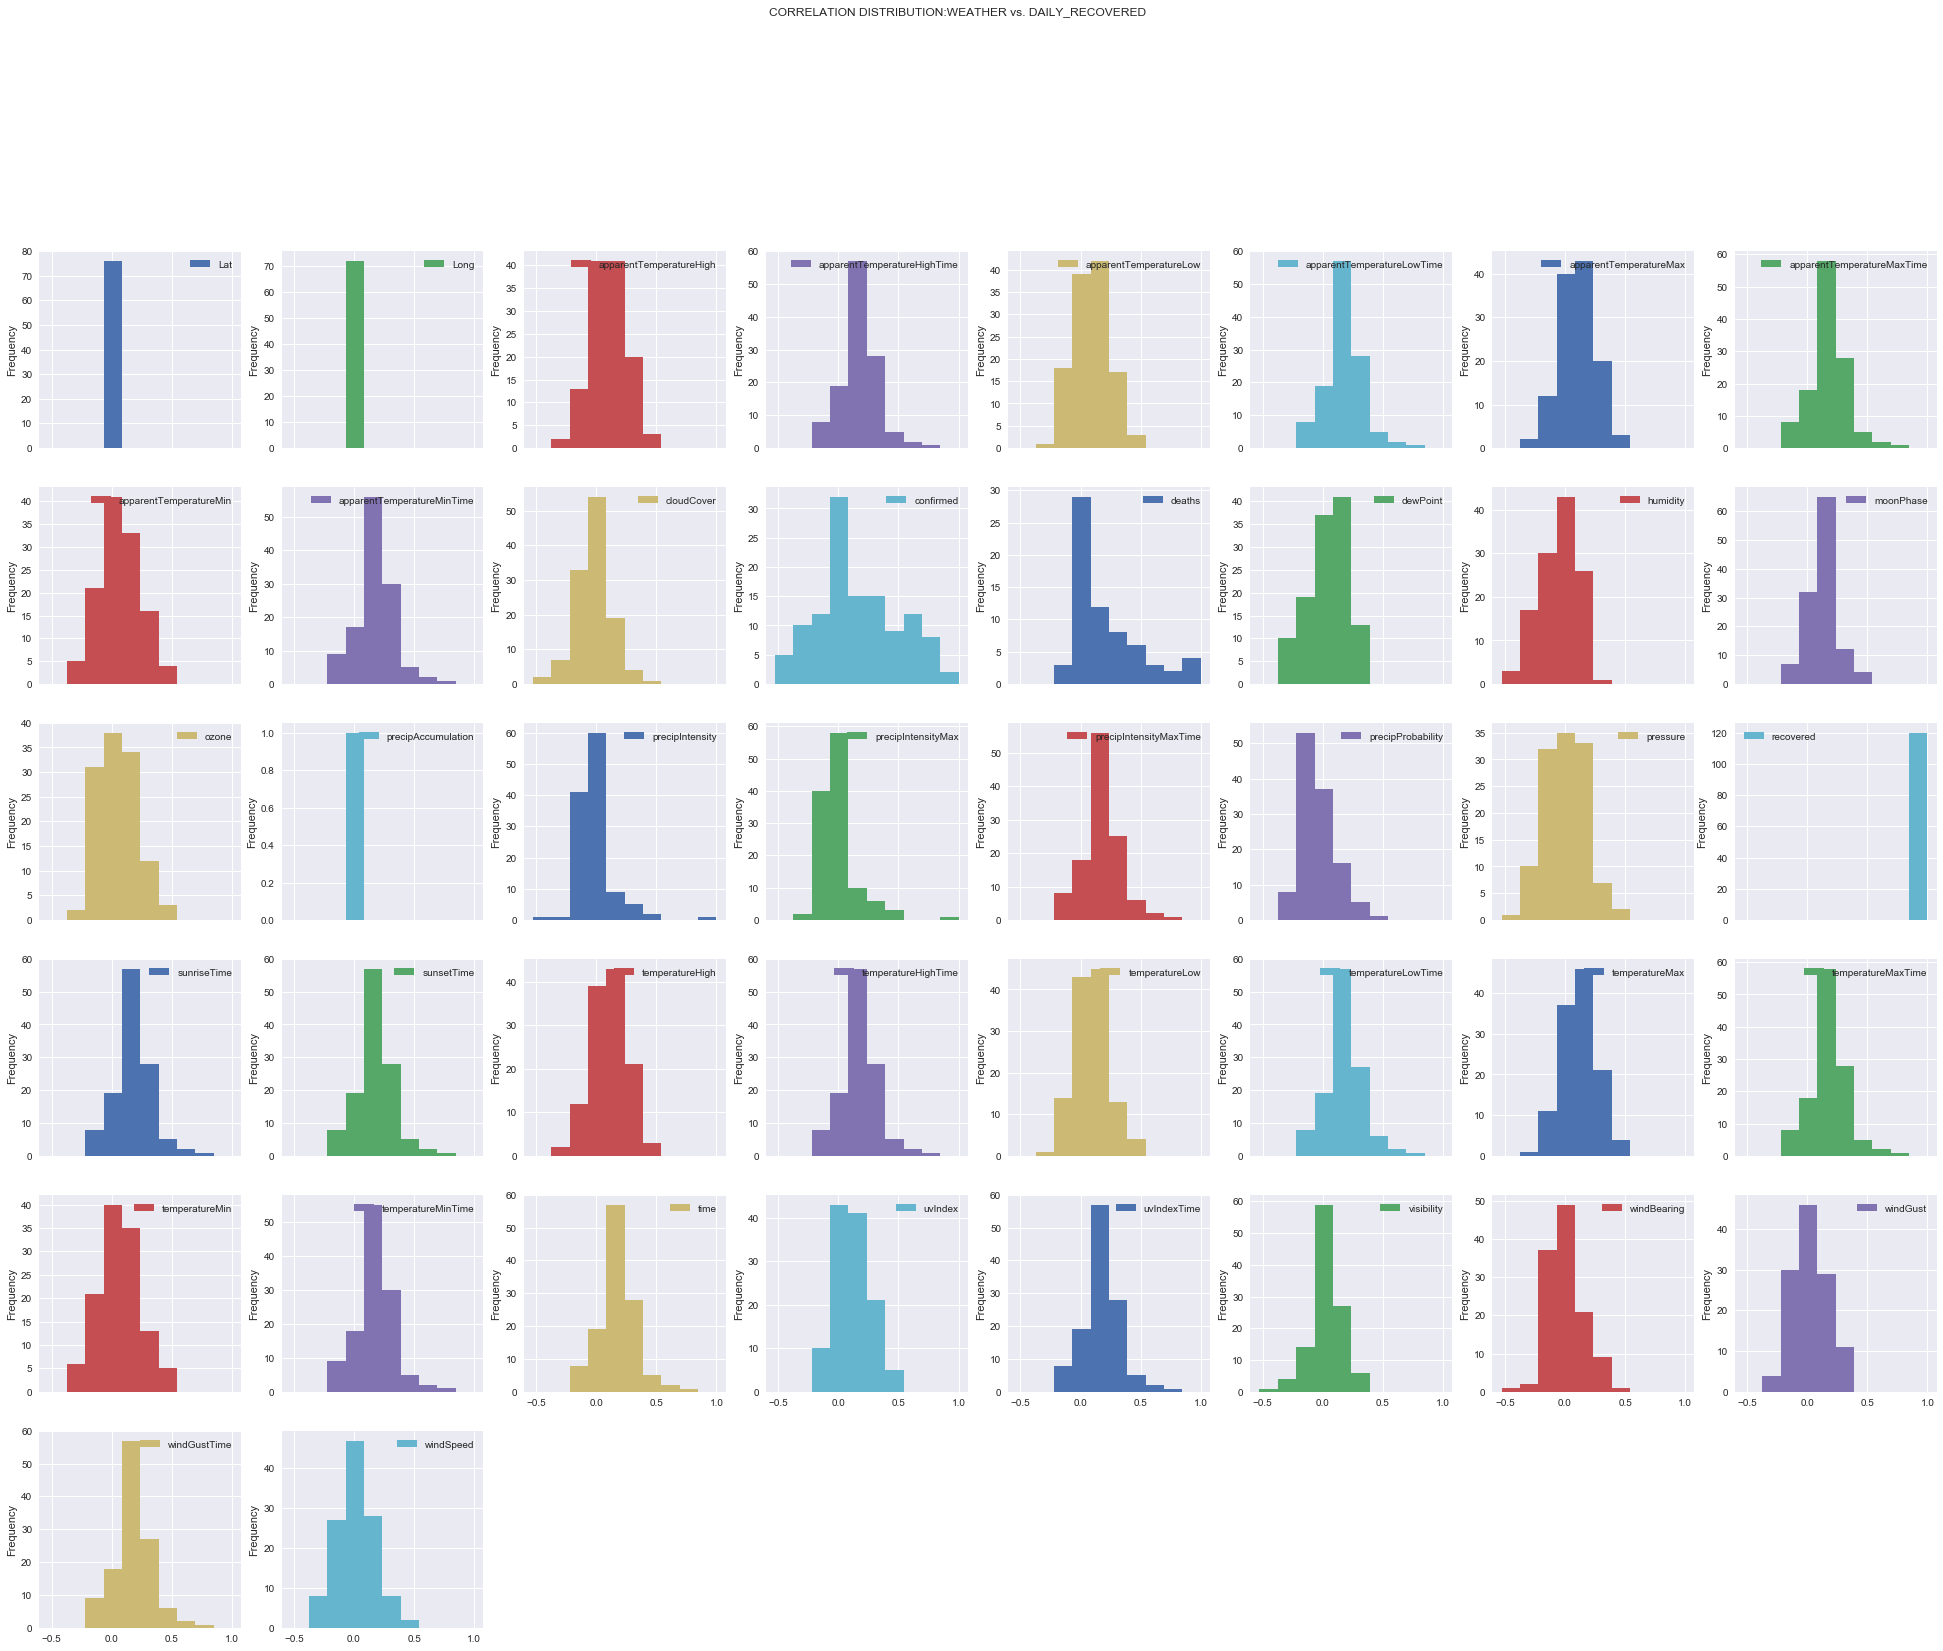

In [341]:
plt.style.use('seaborn')
corr_dfs_recovered.plot.hist(subplots=True, legend=True, 
                             layout=(8, 8),
                             figsize=(34, 34),
                            title = "CORRELATION DISTRIBUTION:WEATHER vs. DAILY_RECOVERED")
plt.show()

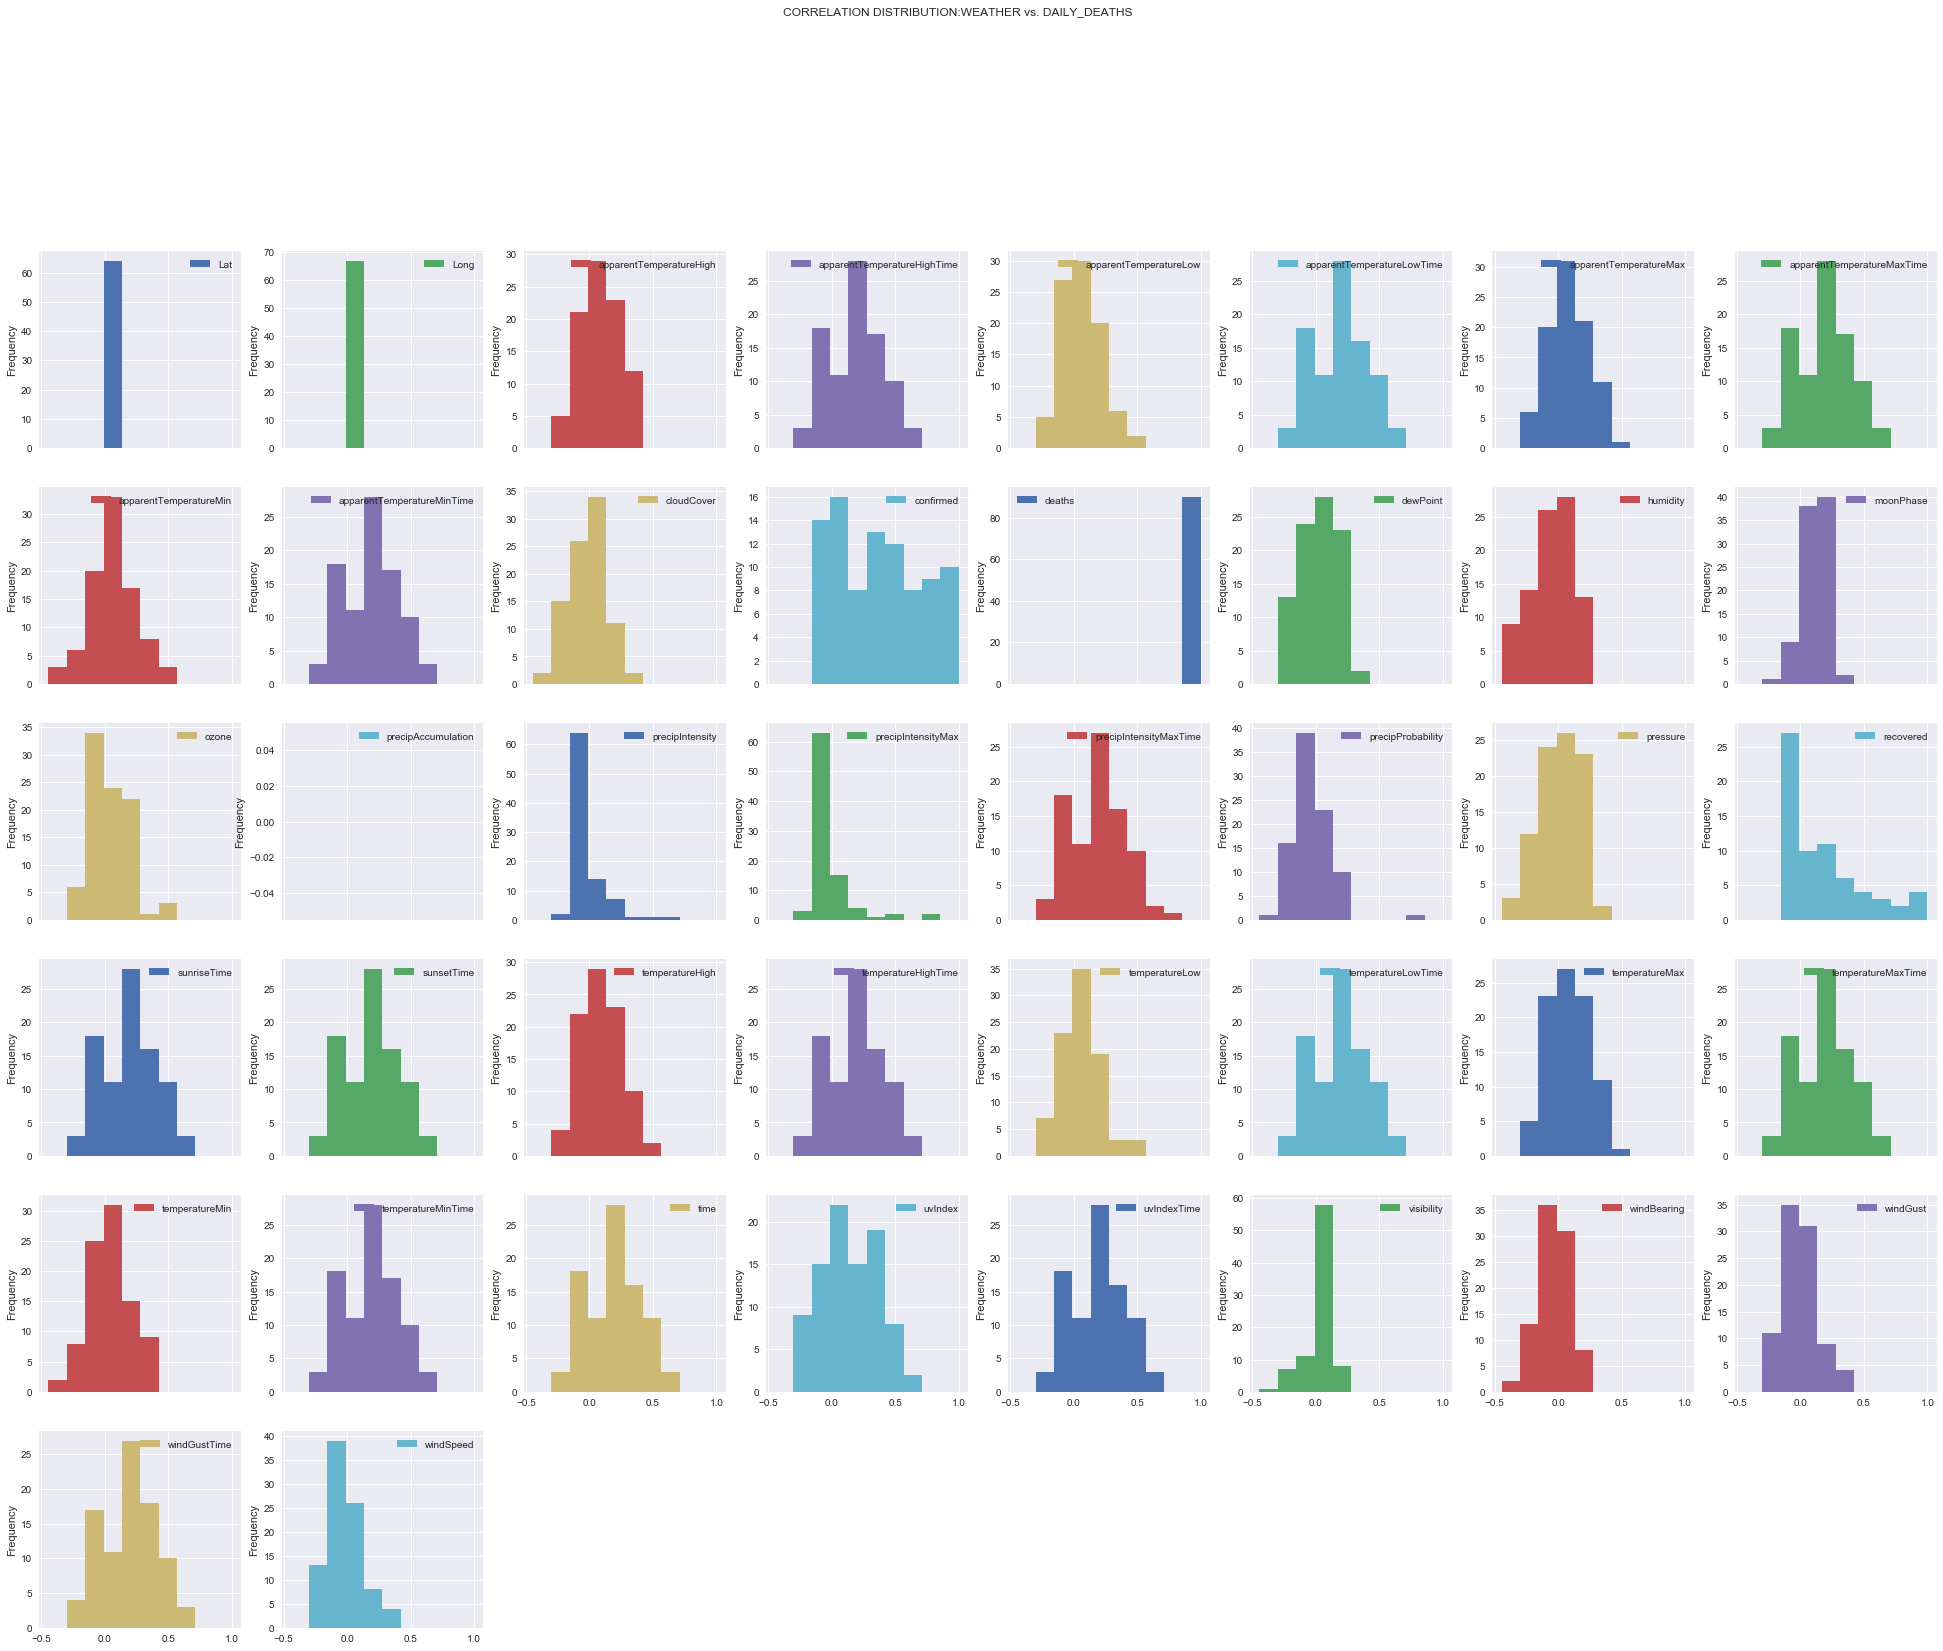

In [342]:
plt.style.use('seaborn')
corr_dfs_deaths.plot.hist(subplots=True, legend=True, 
                             layout=(8, 8),
                             figsize=(34, 34),
                            title = "CORRELATION DISTRIBUTION:WEATHER vs. DAILY_DEATHS")
plt.show()

In [356]:
corr_dfs_confirmed.columns[corr_dfs_confirmed.median(axis=0)>=.4]

Index(['apparentTemperatureHighTime', 'apparentTemperatureLowTime',
       'apparentTemperatureMaxTime', 'apparentTemperatureMinTime', 'confirmed',
       'precipIntensityMaxTime', 'sunriseTime', 'sunsetTime',
       'temperatureHighTime', 'temperatureLowTime', 'temperatureMaxTime',
       'temperatureMinTime', 'time', 'uvIndexTime', 'windGustTime'],
      dtype='object')